In [1]:
%matplotlib inline

import numpy as np
import edward as ed
import pandas as pd
import tensorflow as tf
from edward.models import Categorical, Normal
from keras.utils import to_categorical

import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

plt.style.use('ggplot')

/Users/sabber/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
## Sklearn related modules
from sklearn.utils import shuffle, class_weight
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
random_seed = 2018

In [4]:
ed.set_seed(random_seed)

In [5]:
# inspired by http://nipunbatra.github.io/2014/08/latexify/
plt.style.use(['default'])
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 12, # was 10
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': True,
    'figure.facecolor':'white',
    'font.family': 'serif',
}
plt.rcParams.update(params)

### Import Data

In [6]:
## look data with pandas
train_file = "data/rupturemodel_train.txt"
val_file = "data/rupturemodel_xvalidate.txt"
test_file = "data/rupturemodel_test.txt"

df_train= pd.read_csv(train_file, sep=" ", header = None, dtype = np.float32)
df_val= pd.read_csv(val_file, sep=" ", header = None, dtype = np.float32)
df_test= pd.read_csv(test_file, sep=" ", header = None, dtype = np.float32)

features_name =  ['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc', 'label']
df_train.columns = features_name
df_val.columns = features_name
df_test.columns = features_name

df_train_all = df_train.append(df_val)

### Data processing
We use StandardScaler preprocessing method of scikit. It standardizes features 
by removing the mean and scaling to unit variance

In [7]:
df = shuffle(df_train_all, random_state = random_seed)
df_train = shuffle(df_train, random_state = random_seed)
df_val = shuffle(df_val, random_state = random_seed)
df_test = shuffle(df_test, random_state = random_seed)

mms = StandardScaler()
train_scale = mms.fit(df.drop('label', axis=1))

xtrain = train_scale.transform(df.drop('label', axis=1))
ytrain =  df['label'].values

xtest = train_scale.transform(df_test.drop('label', axis=1))
ytest = df_test['label'].values

# train_y2 = np.argmax(ytrain, axis=1)
# test_y2 = np.argmax(ytest, axis=1)

### Model prior weights

In [8]:
## Hyperparameters
N = np.shape(xtrain)[0]
in_size = np.shape(xtrain)[1]
out_size = np.shape(ytrain)[1]
l1 = 12 # Number of neurons in the first layer
BATCH_SIZE = 32

In [16]:
with tf.name_scope('model_prior'):
    
    W_0 = Normal(loc = tf.zeros([in_size, l1], name="weights/loc_w_0"), 
                 scale=tf.ones([in_size, l1], name="weights/scale_w_0"),
                 name  = 'weight_w_0')
    W_1 = Normal(loc=tf.zeros([l1, out_size], name="weights/loc_w_1"), 
                 scale=tf.ones([l1, out_size], name="weights/scale_w_1"),
                 name  = 'weight_w_1')
    b_0 = Normal(loc=tf.zeros(l1, name="weights/loc_b_0"), 
                 scale=tf.ones(l1, name="weights/scale_b_0"),
                 name  = 'weight_b_0')
    b_1 = Normal(loc=tf.zeros(out_size, name="weights/loc_b_1"),
                 scale=tf.ones(out_size, name="weights/scale_b_1"),
                 name  = 'weight_b_1')
    
#     x_ = tf.placeholder(tf.float32, shape=(None, in_size))
#     y_ = tf.placeholder(tf.int32, shape=(BATCH_SIZE))
    
    h = tf.nn.relu(tf.matmul(x_, W_0) + b_0)
    y = tf.nn.sigmoid(tf.matmul(h, W_1) + b_1)
    X = tf.placeholder(tf.float32, [None, in_size])    

### Inference

In [17]:
with tf.name_scope('posterior'):
    qW_0 = Normal(loc=tf.Variable(tf.random_normal([in_size, l1]), name = "weights/loc_qw_0" ), 
                  scale=tf.Variable(tf.random_normal([in_size, l1]), name = "weights/scale_qw_0"),
                  name = "weight_qw_0")
    
    qW_1 = Normal(loc=tf.Variable(tf.random_normal([l1, out_size]), name = "weights/loc_qw_1" ), 
                  scale=tf.Variable(tf.random_normal([l1, out_size]), name = "weights/loc_qw_1" ),
                  name = "weight_qw_1")
    
    qb_0 = Normal(loc=tf.Variable(tf.random_normal([l1]), name = "weights/loc_qb_0" ), 
                scale=tf.Variable(tf.random_normal([l1]), name = "weights/loc_qb_0" ),
                name = "weight_qb_0")
    qb_1 = Normal(loc=tf.Variable(tf.random_normal([out_size]), name = "weights/loc_qb_1" ), 
                scale=tf.Variable(tf.random_normal([out_size]), name = "weights/loc_qb_1" ),
                name = "weight_qb_1")

In [18]:
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1}, data={X: xtrain, y: ytrain})

global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.05

learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           10000, 0.3, staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate)

inference.run(n_iter=20000, optimizer=optimizer, global_step=global_step)

TypeError: Key-value pair in data does not have same shape: (?,), (1600, 2)

In [13]:
inference = ed.KLqp({W_0: qW_0, b_0: qb_0, W_1: qW_1, b_1: qb_1}, 
                    data = {x_:xtrain, y: y_})

# Initialse the infernce variables
inference.initialize(n_iter=100, logdir='log/samples')

In [14]:
# We will use an interactive session.
sess = tf.InteractiveSession()

# Initialise all the vairables in the session.
tf.global_variables_initializer().run()

In [15]:
for _ in range(inference.n_iter):    
    perm = np.random.permutation(N)
    for i in range(0, N, BATCH_SIZE):
        batch_x = xtrain[perm[i:i+BATCH_SIZE]]
        batch_y = np.argmax(ytrain[perm[i:i+BATCH_SIZE]],axis=1)
        info_dict = inference.update(feed_dict={x_: batch_x, y_: batch_y})
#         inference.print_progress(info_dict)

InvalidArgumentError: Incompatible shapes: [1600,2] vs. [32,1]
	 [[Node: inference/sample/model_prior/Categorical/log_prob/mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](inference/sample/model_prior/Sigmoid, inference/sample/model_prior/Categorical/log_prob/ones_like)]]

Caused by op 'inference/sample/model_prior/Categorical/log_prob/mul', defined at:
  File "/Users/sabber/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/sabber/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/Users/sabber/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/Users/sabber/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/Users/sabber/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2909, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-db67c790f928>", line 5, in <module>
    inference.initialize(n_iter=100, logdir='log/samples')
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/edward/inferences/klqp.py", line 110, in initialize
    return super(KLqp, self).initialize(*args, **kwargs)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/edward/inferences/variational_inference.py", line 68, in initialize
    self.loss, grads_and_vars = self.build_loss_and_gradients(var_list)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/edward/inferences/klqp.py", line 145, in build_loss_and_gradients
    return build_reparam_kl_loss_and_gradients(self, var_list)
  File "/Users/sabber/anaconda3/lib/python3.6/site-packages/edward/inferences/klqp.py", line 724, in build_reparam_kl_loss_and_gradients
    inference.scale.get(x, 1.0) * x_copy.log_prob(dict_swap[x]))
  File "/Users/sabber/.local/lib/python3.6/site-packages/tensorflow/python/ops/distributions/distribution.py", line 709, in log_prob
    return self._call_log_prob(value, name)
  File "/Users/sabber/.local/lib/python3.6/site-packages/tensorflow/python/ops/distributions/distribution.py", line 691, in _call_log_prob
    return self._log_prob(value, **kwargs)
  File "/Users/sabber/.local/lib/python3.6/site-packages/tensorflow/python/ops/distributions/categorical.py", line 300, in _log_prob
    k, self.logits, base_dtype=self.dtype.base_dtype)
  File "/Users/sabber/.local/lib/python3.6/site-packages/tensorflow/python/ops/distributions/categorical.py", line 54, in _broadcast_cat_event_and_params
    array_ops.expand_dims(event, -1), dtype=params.dtype)
  File "/Users/sabber/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 907, in binary_op_wrapper
    return func(x, y, name=name)
  File "/Users/sabber/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1131, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "/Users/sabber/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2798, in _mul
    "Mul", x=x, y=y, name=name)
  File "/Users/sabber/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/sabber/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/Users/sabber/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Incompatible shapes: [1600,2] vs. [32,1]
	 [[Node: inference/sample/model_prior/Categorical/log_prob/mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](inference/sample/model_prior/Sigmoid, inference/sample/model_prior/Categorical/log_prob/ones_like)]]


In [14]:
ytest2 = np.argmax(ytest,axis=1)

In [39]:
import sys
# Generate samples the posterior and store them.
n_samples = 100
prob_lst = []
samples = []

w_0_samples = []
b_0_samples = []
w_1_samples = []
b_1_samples = []

for _ in range(n_samples):
    w_0_samp = qW_0.sample()
    b_0_samp = qb_0.sample()
    w_1_samp = qW_1.sample()
    b_1_samp = qb_1.sample()
    
    w_0_samples.append(w_0_samp)
    w_1_samples.append(w_1_samp)
    b_0_samples.append(b_0_samp)
    b_1_samples.append(b_1_samp)
    
    # prediction on test data
    h = tf.nn.relu(tf.matmul(xtest.astype('float32'), w_0_samp) + b_0_samp)
    y_pred = tf.nn.sigmoid(tf.matmul(h, w_1_samp) + b_1_samp)
    
    ## Probability calculation using softmax
    prob = tf.nn.softmax(y_pred)
    prob_lst.append(y_pred.eval())
    
#     sample = tf.concat([tf.reshape(w_samp,[-1]), b_samp],0)
#     samples.append(sample.eval())

In [34]:
np.shape(prob_lst)

(100, 400, 2)

Text(0,0.5,'Frequency')

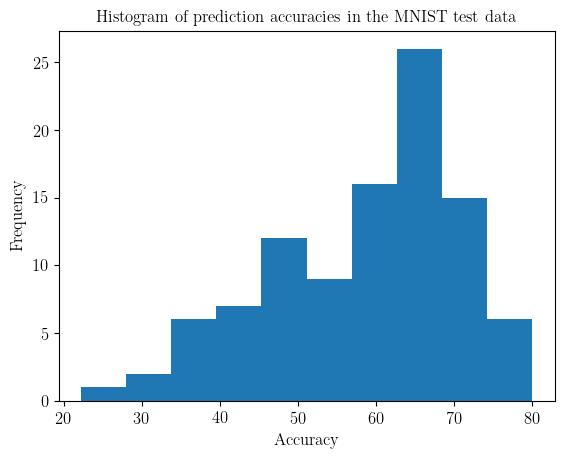

In [40]:
accy_test = []
for prob in prob_lst:
    y_trn_prd = np.argmax(prob, axis=1).astype(np.float32)
    ytest2 = np.argmax(ytest, axis=1).astype(np.float32)
    
    acc = (y_trn_prd == ytest2).mean()*100
    accy_test.append(acc)

plt.hist(accy_test)
plt.title("Histogram of prediction accuracies in the MNIST test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")

In [46]:
ypred = np.argmax(np.mean(prob_lst,axis=0),axis=1)
ytest2 = np.argmax(ytest, axis=1).astype(np.float32)

print("accuracy in predicting the test data = ", (Y_pred == ytest2).mean()*100)

accuracy in predicting the test data =  68.0


In [56]:
np.argmax(prob_lst[0], axis = 1)

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,

In [42]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [48]:
def prediction(ytest, ypred):
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))

In [57]:
ypred = np.argmax(prob_lst[0], axis = 1)

In [58]:
prediction(ytest2, ypred)

Accuracy of the model: 0.575

Classification report: 
             precision    recall  f1-score   support

        0.0       0.67      0.75      0.70       272
        1.0       0.28      0.21      0.24       128

avg / total       0.54      0.57      0.56       400


Confusion matrix: 
[[203  69]
 [101  27]]

